<a href="https://colab.research.google.com/github/TiphaineV/gpeg/blob/heavy/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Files

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import scipy.sparse as sparse

In [2]:
!pip install memory-profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp36-none-any.whl size=30181 sha256=d3c97c1ec0428f76235d85d457563fbefc60c904a7c2a3e33190bcc0c061bde9
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [3]:
%load_ext memory_profiler

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# -- Adapt it with the id of your files
userfile_id = '1SujkUIqpPKg9LlJ8s77upbeTKkenmrLc'
adjency_id = '1Oz8rbp1HOb9EB_7dZYLQdVJ09oAyMlWB'

In [6]:
# -- some cleaning
needed = True
if needed :
  %rm -R gpeg/
  %rm context.py
  %rm fastGraph.py
  %rm node.py
  %rm _recSystems.py
  %rm trivialClf.py
  %rm edge.py
  %rm main.py 
  %rm scorer.py

rm: cannot remove 'gpeg/': No such file or directory
rm: cannot remove 'context.py': No such file or directory
rm: cannot remove 'fastGraph.py': No such file or directory
rm: cannot remove 'node.py': No such file or directory
rm: cannot remove '_recSystems.py': No such file or directory
rm: cannot remove 'trivialClf.py': No such file or directory
rm: cannot remove 'edge.py': No such file or directory
rm: cannot remove 'main.py': No such file or directory
rm: cannot remove 'scorer.py': No such file or directory


In [7]:
!git clone -b heavy https://github.com/TiphaineV/gpeg.git

Cloning into 'gpeg'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 481 (delta 211), reused 197 (delta 113), pack-reused 166
Receiving objects: 100% (481/481), 1.06 MiB | 3.36 MiB/s, done.
Resolving deltas: 100% (299/299), done.


In [8]:
cd gpeg/fast_implementation/

/content/gpeg/fast_implementation


In [9]:
# Modules
import numpy as np
from _recSystems import _Clf
from fastGraph import Graph
from trivialClf import TrivialClf
from scorer import ClfScorer
from features import StandardFeatures

In [22]:
adjencyBool = True
userDataBool = False

In [23]:
# -- Loading userData (heavy, takes around a minute)
downloaded = drive.CreateFile({'id':userfile_id}) 
downloaded.GetContentFile('userData.csv')
if userDataBool:
    userDataStream = pd.read_csv('userData.csv', chunksize= 1e6) # please don't change chuksize

In [12]:
# -- Loading adjency 
if adjencyBool:
    downloaded = drive.CreateFile({'id':adjency_id}) 
    downloaded.GetContentFile('adjency-20M.npz')

## Building Adjency Matrix

In [13]:
%%time
# -- Graph construction, nChunk * 1e6 rows are processed from movieLens 20M.
# -- Takes around 2'30 for one chunk
%memit graph = Graph(path = 'adjency-20M.npz')

Graph init ...
peak memory: 1004.11 MiB, increment: 692.41 MiB
CPU times: user 2.05 s, sys: 360 ms, total: 2.41 s
Wall time: 2.54 s


## Graph split

In [14]:
%%time
# -- Parameters
alpha = 0.1 # test proportion in the split

# -- train_test_split
%memit trainEdges, testEdges = graph.train_test_split(alpha= alpha)

peak memory: 2238.55 MiB, increment: 1234.41 MiB
CPU times: user 41.1 s, sys: 826 ms, total: 41.9 s
Wall time: 42.1 s


## Classification

In [24]:
# -- Loading userData
%memit userData = pd.read_csv('userData.csv')

peak memory: 6415.44 MiB, increment: 3179.82 MiB


In [25]:
print(userData.head(10))

   Unnamed: 0  userId  movieId  rating     timestamp_rating  tag timestamp_tag
0           0       1        2     3.5  2005-04-02 23:53:47  NaN           NaN
1           1       1       29     3.5  2005-04-02 23:31:16  NaN           NaN
2           2       1       32     3.5  2005-04-02 23:33:39  NaN           NaN
3           3       1       47     3.5  2005-04-02 23:32:07  NaN           NaN
4           4       1       50     3.5  2005-04-02 23:29:40  NaN           NaN
5           5       1      112     3.5  2004-09-10 03:09:00  NaN           NaN
6           6       1      151     4.0  2004-09-10 03:08:54  NaN           NaN
7           7       1      223     4.0  2005-04-02 23:46:13  NaN           NaN
8           8       1      253     4.0  2005-04-02 23:35:40  NaN           NaN
9           9       1      260     4.0  2005-04-02 23:33:46  NaN           NaN


In [26]:
# -- Getting feature functions
featFncts = StandardFeatures.get_featFncts()

In [27]:
# -- Fitting recommender system
clf = TrivialClf(userData, graph.adjency, featFncts)
%memit clf.fit(trainEdges)

peak memory: 8335.49 MiB, increment: 1919.42 MiB


## Scoring predictions

In [28]:
# -- Prediction (quite long because linear in nb of edges)
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

random prop 0.884169


In [29]:
print(classification_report(yTrue, yPred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79   1879131
           1       0.06      0.32      0.10    120869

    accuracy                           0.66   2000000
   macro avg       0.50      0.50      0.44   2000000
weighted avg       0.89      0.66      0.75   2000000



In [30]:
sample = np.random.choice(range(len(yPred)), size = 10)
print(sample)

[ 624356 1112098 1536539 1939300 1121654  862319  171965  300172 1084478
  922828]


In [31]:
print('Predictions \n', yPred.iloc[sample].astype('uint8'))

Predictions 
 706856     1
1258744    1
1737582    0
1476634    1
1269564    0
976928     0
193364     0
339540     1
1227658    0
1045295    0
dtype: uint8


In [32]:
print('Ground truth labels \n', yTrue.iloc[sample])

Ground truth labels 
 624356     0
1112098    0
1536539    0
1939300    0
1121654    0
862319     0
171965     0
300172     0
1084478    0
922828     0
Name: rating, dtype: uint8


In [ ]:
# -- Scoring
#scorer = ClfScorer()
#%memit score = scorer.score(clf, testEdges) 

## Some Exploratory Data Analysis

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

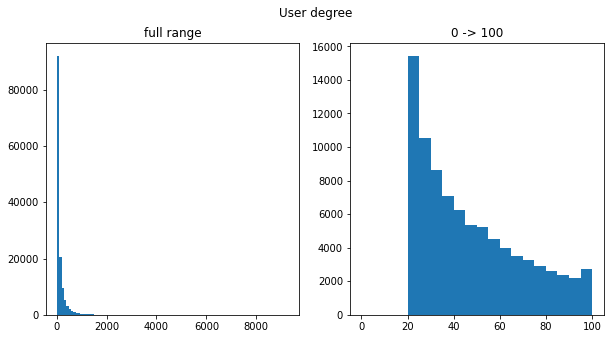

In [34]:
n = graph.rowFormat.shape[0]
degreeDist = [graph.rowFormat[i].nnz for i in range(1,n)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('User degree')
ax1.hist(degreeDist, bins= 100)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 20, range=(0,100))
ax2.set_title('0 -> 100')
plt.show()

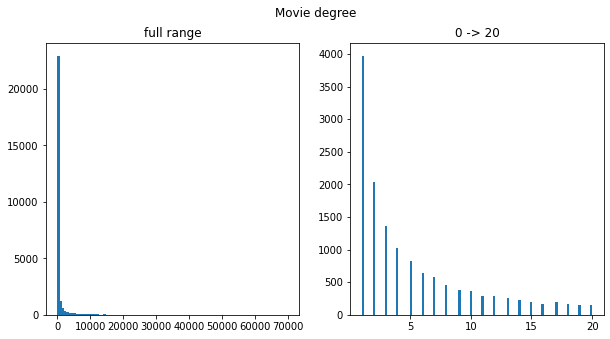

In [35]:
m = graph.colFormat.shape[1]
degreeDist = [graph.colFormat[:,i].nnz for i in range(1,m)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Movie degree')
ax1.hist(degreeDist, bins= 100, range= (1, 70000), log=False)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 100, range=(1,20), log= False)
ax2.set_title('0 -> 20')
plt.show()

weight of the first degrees 0.6706652126499455


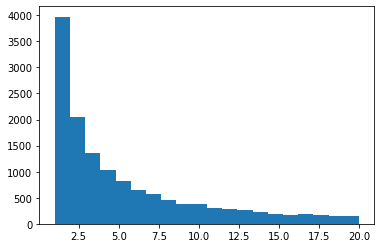

In [36]:
count = plt.hist(degreeDist, bins = 20, range=(1,20), log= False)[0]

print('weight of the first degrees', np.sum(count[[0,1,2,3,4]]) /np.sum(count))

**Remarks** : 

When predicting the class of an edge (user, movie) we assume we have gathered underlying data on the user or on the movie during the fit on the training data.
However, because a lot of movies are seen once or twice, with a non negligible probability, we might have to classify an edge for which the movie has not been seen.

**Solution** :

A way to tackle this problem is to threshold the data set by the movie degrees.